In [1]:
import os, json, pickle, pprint, math
import urllib.parse
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
cm_entities = pickle.load(open("/home/rovera/cm/scripts/generators/generator_all_entities/cm_tagme_resource_reference_data_06_04.pickle", 'rb'))

In [3]:
entity_classification = json.load(open('/data/cm/data/entity_classification/entity_classification.json', 'r', encoding='utf-8'))
id_to_journal = json.load(open('/home/rovera/cm/scripts/cooccurrence/input/id_to_journal.json', 'r', encoding="utf-8"))
journal_to_id = json.load(open('/home/rovera/cm/scripts/cooccurrence/input/journal_to_id.json', 'r', encoding="utf-8"))

In [4]:
labeled, not_labeled = 0, 0
for entity, val in entity_classification.items():
    if len(val['cats']) == 0:
        not_labeled +=1
    else:
        labeled += 1
print("Labeled {} entities, not labeled {} entities.".format(labeled, not_labeled))

Labeled 117072 entities, not labeled 36260 entities.


In [5]:
def unquote_urls(cm_entities):
    for mention in cm_entities:
        mention['wiki'] = urllib.parse.unquote(mention['wiki'])
        mention['dbpedia'] = urllib.parse.unquote(mention['dbpedia'])
unquote_urls(cm_entities)

In [6]:
cm_entities[0]

{'wiki': 'https://de.wikipedia.org/wiki/Gustav_Wyneken',
 'dbpedia': 'http://dbpedia.org/resource/Gustav_Wyneken',
 'spot': 'Gustav Wyneken',
 'start': 1716,
 'end': 1730,
 'link_prob': 1,
 'rho': 0.5213567614555359,
 'journal_id': '2710055',
 'page_id': '2710055-2710056-2710060--083-2710159'}

In [7]:
# filter entities out entities if they are not on dbpedia or do not have a class
out = set([])
print(len(cm_entities))
cm_entities_filtered = []
prefix = 'https://de.wikipedia.org/wiki/'
for mention in cm_entities:
    entity_uri = mention['wiki']
    label = entity_uri.strip(prefix)
    try:
        if len(entity_classification[label]['cats']) != 0:
            cm_entities_filtered.append(mention)
    except KeyError:
        out.add(entity_uri)
print(len(cm_entities_filtered))

6572818
1966143


In [8]:
# filter out entities by class
cm_entities_filtered_by_class = []
for mention in cm_entities_filtered:
    entity_uri = mention['wiki']
    label = entity_uri.strip(prefix)
    mention_cats = set(entity_classification[label]['cats'])
    
    black_entity = False
    for black_list in (pers_black, orgs_black, events_black):
        if len(mention_cats.intersection(black_list)) != 0:
            black_entity = True
    if not black_entity:
        cm_entities_filtered_by_class.append(mention)
        
print(len(cm_entities_filtered_by_class))

1960393


In [7]:
def get_uri_name_mapping(cm_mentions, general=False):
    field = '' # field in cm_entities which identifies the resource
    if general:
        field = 'wiki'
    else:
        field = 'resource'
    uri_to_name = {mention[field]: mention[field].split('/')[-1] for mention in cm_entities}
    uri_to_name = {k: v.replace('_', ' ') for k,v in uri_to_name.items()}
    name_to_uri = {v: k for k,v in uri_to_name.items()}
    return uri_to_name, name_to_uri

def group_by_page(cm_entities, general=False):
    field = '' # field in cm_entities which identifies the resource
    if general:
        field = 'wiki'
    else:
        field = 'resource'
    ents_by_page = {}
    for mention in cm_entities:
        if mention['page_id'] not in ents_by_page:
            ents_by_page[mention['page_id']] = set([])
        ents_by_page[mention['page_id']].add((mention[field], int(mention['start']), int(mention['end'])))
    return ents_by_page


def group_by_journal(cm_entities, general=False):
    field = '' # field in cm_entities which identifies the resource
    if general:
        field = 'wiki'
    else:
        field = 'resource'
    occ_by_journal = {}
    for mention in cm_entities:
        if mention[field] not in occ_by_journal:
            occ_by_journal[mention[field]] = {}
        if mention['journal_id'] not in occ_by_journal[mention[field]]:
            occ_by_journal[mention[field]][mention['journal_id']] = 0
        occ_by_journal[mention[field]][mention['journal_id']] += 1
    return occ_by_journal

def get_occ_by_journal(resource_uri, occ_by_journal, id_to_journal, return_data=False):
    sorted_occ = sorted([(k,v) for k,v in occ_by_journal[resource_uri].items()], key=lambda x:x[1], reverse=True)
    if return_data == False:
        for journal in sorted_occ:
            print(id_to_journal[journal[0]], journal[1])
    else:
        return sorted_occ

def get_dataset_info(ents_by_page, entity_count):
    pages = len(ents_by_page)
    unique_entities = len(entity_count)
    mention_count = sum(len(v) for v in ents_by_page.values())
    avg = mention_count/len(ents_by_page)
    print("Found {} entity mentions in {} pages ({} mentions/page), {} unique entities.".format(mention_count, pages, avg, unique_entities))

def count_entity_occurrence(cm_entities, general=False):
    field = '' # field in cm_entities which identifies the resource
    if general:
        field = 'wiki'
    else:
        field = 'resource'
    occ = {}
    for mention in cm_entities:
        if mention[field] not in occ:
            occ[mention[field]] = 0
        occ[mention[field]] += 1
    return occ
        

def get_cooccurrence(ents_by_page, offset=400):
    cooc = {}
    for pool in ents_by_page.values():
        for entity in pool:
            if entity[0] not in cooc:
                cooc[entity[0]] = {}
            for cooccurrent in pool:
                if cooccurrent[0] != entity[0] and abs(cooccurrent[1]-entity[1]) < offset:
                    if cooccurrent[0] not in cooc[entity[0]]:
                        cooc[entity[0]][cooccurrent[0]] = 0
                    cooc[entity[0]][cooccurrent[0]] += 1
    return cooc

def get_top_10_cooccurrents(resource_uri, cooc_dict):
    if resource_uri not in cooc_dict:
        print("The resource {} is not available in the dataset.".format(resource_uri))
    else:
        sorted_cooccurrents = sorted([(k,v) for k,v in cooc_dict[resource_uri].items()], key=lambda x:x[1], reverse=True)
        for i in range(10):
            if i < len(sorted_cooccurrents):
                print(sorted_cooccurrents[i])

            

def get_pmi_correlation(entity_count, cooc):
    tot_entities = sum(entity_count.values())
    pmi_corr = {k: {} for k in entity_count.keys()}
    for occurrent, cooccurrents in cooc.items():
        for cooccurrent, abs_cooc in cooccurrents.items():
            occurrent_count = entity_count[occurrent]
            cooccurrent_count = entity_count[cooccurrent]
            pmi_value = math.log((abs_cooc/tot_entities)/((occurrent_count/tot_entities)*(cooccurrent_count/tot_entities)))
            pmi_corr[occurrent][cooccurrent] = pmi_value
    return pmi_corr

def avg(a,b):
    return (a+b)/2

def get_custom_correlation(entity_count, cooc):
    custom_corr = {k: {} for k in entity_count.keys()}
    for occurrent, cooccurrents in cooc.items():
        for cooccurrent, abs_cooc in cooccurrents.items():
            occurrent_count = entity_count[occurrent]
            cooccurrent_count = entity_count[cooccurrent]
            
            custom_value = abs_cooc/((occurrent_count+cooccurrent_count)/2)
            custom_corr[occurrent][cooccurrent] = custom_value
    return custom_corr

def get_top_10_custom_correlated(resource_uri, custom_corr):
    sorted_correlations = sorted([(k,v) for k,v in custom_corr[resource_uri].items()], key=lambda x:x[1], reverse=True)
    for i in range(10):
        if i < len(sorted_correlations):
            print(sorted_correlations[i])
            
def get_all_correlated(resource_uri, custom_corr, return_data=False):
    sorted_correlations = sorted([(k,v) for k,v in custom_corr[resource_uri].items()], key=lambda x:x[1], reverse=True)
    if return_data:
        return sorted_correlations
    else:
        for el in sorted_correlations:
            print(el)
    
def get_top_10_correlated(resource_uri, pmi_corr):
    sorted_correlations = sorted([(k,v) for k,v in pmi_corr[resource_uri].items()], key=lambda x:x[1], reverse=True)
    for i in range(10):
        if i < len(sorted_correlations):
            print(sorted_correlations[i])

In [8]:
# count mentions
entity_count = count_entity_occurrence(cm_entities, general=True)
pickle.dump(entity_count, open('/data/cm/output/correlation_analysis/entity_count.pickle', 'wb'))

# group entities by page
ents_by_page = group_by_page(cm_entities, general=True)

# print dataset information
get_dataset_info(ents_by_page, entity_count)

# compute absoute cooccurrence (offset required, default 400 characters)
cooc_dict_abs = get_cooccurrence(ents_by_page, offset=200)

Found 6572818 entity mentions in 726785 pages (9.043689674387887 mentions/page), 153332 unique entities.


In [9]:
# compute custom correlation between entities using custom measure
custom_corr_dict = get_custom_correlation(entity_count, cooc_dict_abs)
pickle.dump(custom_corr_dict, open('/data/cm/output/correlation_analysis/correlation_dict.pickle', 'wb'))

In [10]:
for k,v in cooc_dict_abs.items():
    print(k,v)
    break

https://de.wikipedia.org/wiki/Gustav_Wyneken {'https://de.wikipedia.org/wiki/Franz_Mehring': 1, 'https://de.wikipedia.org/wiki/Rudolf_Pannwitz': 1, 'https://de.wikipedia.org/wiki/Georg_Bondi_Verlag': 1, 'https://de.wikipedia.org/wiki/Hans_Blüher': 4, 'https://de.wikipedia.org/wiki/Breslau': 1, 'https://de.wikipedia.org/wiki/Heinrich_Mann': 3, 'https://de.wikipedia.org/wiki/Max_Brod': 3, 'https://de.wikipedia.org/wiki/Fritz_Jöde': 1, 'https://de.wikipedia.org/wiki/HaPoel_HaZair': 1, 'https://de.wikipedia.org/wiki/Die_Neue_Erziehung': 1, 'https://de.wikipedia.org/wiki/Wei_Man': 1, 'https://de.wikipedia.org/wiki/Montessoripädagogik': 1, 'https://de.wikipedia.org/wiki/Berthold_Otto': 1, 'https://de.wikipedia.org/wiki/Siegfried_Bernfeld': 1, 'https://de.wikipedia.org/wiki/Maria_Montessori': 2, 'https://de.wikipedia.org/wiki/Joseph_Wirth': 1, 'https://de.wikipedia.org/wiki/Clara_Zetkin': 1, 'https://de.wikipedia.org/wiki/Quers': 1, 'https://de.wikipedia.org/wiki/Georg_Stammler': 2, 'https://

In [11]:
# query for custom correlation
get_top_10_custom_correlated('https://de.wikipedia.org/wiki/Irak', custom_corr_dict)

('https://de.wikipedia.org/wiki/Bagdad', 0.09109499907045919)
('https://de.wikipedia.org/wiki/Transjordanien', 0.09080208508491676)
('https://de.wikipedia.org/wiki/Syrien', 0.07394684505514373)
('https://de.wikipedia.org/wiki/Libanon', 0.039226622048707936)
('https://de.wikipedia.org/wiki/Iran', 0.031713281369402414)
('https://de.wikipedia.org/wiki/Jemen', 0.027700316043874327)
('https://de.wikipedia.org/wiki/Hedschas', 0.024539877300613498)
('https://de.wikipedia.org/wiki/Saudi-Arabien', 0.02416806097787693)
('https://de.wikipedia.org/wiki/Emir', 0.023424428332403796)
('https://de.wikipedia.org/wiki/Ägypten', 0.022680795686930655)


In [12]:
entity_classification['Irak']

{'cats': ['http://www.w3.org/2002/07/owl#Thing',
  'http://dbpedia.org/ontology/Place',
  'http://dbpedia.org/ontology/Location',
  'http://www.w3.org/2003/01/geo/wgs84_pos#SpatialThing',
  'http://schema.org/Country',
  'http://schema.org/Place',
  'http://www.wikidata.org/entity/Q6256',
  'http://dbpedia.org/ontology/Country',
  'http://dbpedia.org/ontology/PopulatedPlace'],
 'p': True}

In [13]:
get_all_correlated('https://de.wikipedia.org/wiki/U_Thant', custom_corr_dict)

('https://de.wikipedia.org/wiki/Vereinte_Nationen', 0.029449423815621004)
('https://de.wikipedia.org/wiki/Abba_Eban', 0.026634382566585953)
('https://de.wikipedia.org/wiki/Michael_S._Comay', 0.024054982817869417)
('https://de.wikipedia.org/wiki/Vietnam', 0.0213903743315508)
('https://de.wikipedia.org/wiki/Pakistan', 0.01718213058419244)
('https://de.wikipedia.org/wiki/Vietnamkrieg', 0.01718213058419244)
('https://de.wikipedia.org/wiki/Noa_Eshkol', 0.01348314606741573)
('https://de.wikipedia.org/wiki/Dag_Hammarskjöld', 0.010309278350515464)
('https://de.wikipedia.org/wiki/Paul_VI.', 0.010309278350515464)
('https://de.wikipedia.org/wiki/Golf_von_Akaba', 0.010309278350515464)
('https://de.wikipedia.org/wiki/Arabische_Liga', 0.008347245409015025)
('https://de.wikipedia.org/wiki/Levi_Eschkol', 0.008116883116883116)
('https://de.wikipedia.org/wiki/Europarat', 0.006872852233676977)
('https://de.wikipedia.org/wiki/Sicherheitsrat_der_Vereinten_Nationen', 0.006872852233676976)
('https://de.wikip

In [ ]:
locs = tuple([
    "http://dbpedia.org/ontology/Place",
    "http://dbpedia.org/ontology/Location",
    "http://schema.org/Place"
])

pers = tuple([
    "http://xmlns.com/foaf/0.1/Person",
    "http://dbpedia.org/ontology/Person",
    "http://schema.org/Person"
])

orgs = tuple([
    "http://schema.org/Organization",
    "http://dbpedia.org/ontology/Organisation"
])
events = tuple([
    "http://schema.org/Event",
    "http://dbpedia.org/ontology/Event"
])

per_black = tuple([
    'http://dbpedia.org/ontology/TennisPlayer',
    'http://dbpedia.org/ontology/VolleyballPlayer',
    'http://dbpedia.org/ontology/CrossCountrySkier',
     'http://dbpedia.org/ontology/Curler',
     'http://dbpedia.org/ontology/Cyclist',
    'http://dbpedia.org/ontology/DTMRacer',
    'http://dbpedia.org/ontology/FigureSkater',
    'http://dbpedia.org/ontology/GolfPlayer'
])
event_black = tuple([
    'http://dbpedia.org/ontology/SoccerTournament',
    'http://dbpedia.org/ontology/SportsEvent',
])
orgs_black = tuple([
    'http://dbpedia.org/ontology/SoccerClub',
])

In [159]:
# create ego network
# create node data

i = 0
node2i = {}
node_data = []
for entity_url in custom_corr_dict.keys():
    label = entity_url.split('/')[-1]
    freq = entity_count[entity_url]
    node = tuple([i, {'name': label, 'freq': freq}])
    if label not in node2i:
        node_data.append(node)
        node2i[entity_url] = i
        i+= 1
i2node = {i: node for node, i in node2i.items()}

In [163]:
# create edge data
edge_data = []
for entity_url, correlations in custom_corr_dict.items():
    entity_id = node2i[entity_url]
    for correlated_uri, score in correlations.items():
        correlated_id = node2i[correlated_uri]
        edge = tuple([entity_id, correlated_id, {'weight': score}])
        edge_data.append(edge)

In [158]:
G = nx.Graph()

In [161]:
G.add_nodes_from(node_data)

In [164]:
G.add_edges_from(edge_data)

In [167]:
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 153332\nNumber of edges: 1498563\nAverage degree:  19.5466'

In [168]:
u_thant_ego = nx.ego_graph(G, node2i["https://de.wikipedia.org/wiki/U_Thant"])

In [ ]:
app = Viewer(u_thant_ego)
app.mainloop()

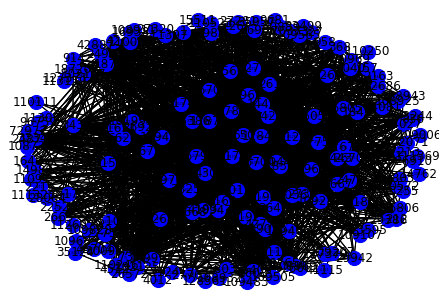

In [192]:
# Draw graph
pos = nx.fruchterman_reingold_layout(u_thant_ego, k=0.3)
nx.draw(u_thant_ego, pos, node_color="b", node_size=50, with_labels=True)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx(u_thant_ego, with_labels=True, node_size=200, width=1, font_size = 3, node_color='b',pos=pos)

plt.savefig("ego.pdf")
plt.show()
